# Reinforcement learning in non-Ergodic context: 
## Hyperparameter sweeps
Adpated code from Cluster run: Changes include
1. No argument passing from source-file for external hyperparameter selection for parallel processing (script-based)
2. Internal extension of decay-strategy loop
3. Extension to include model generalizability for random reward vectors
4. Omitting Data Loading Routine as a consequence as hyperparameters are selected internally (but with the same rules)

# Imports

In [1]:
# ------------------------- [Imports] -------------------------
import argparse
import csv
import datetime as dt
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
import time
import shutil
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm, pareto

# Data loading Routines

In [2]:
if 0:
    # Path to your CSV file
    csv_file = f"{os.getcwd()}/hyperparameters.csv"

    # Function to convert type string to actual type
    def str_to_type(type_str):
        if type_str == 'int':
            return int
        elif type_str == 'float':
            return float
        elif type_str == 'str':
            return str
        else:
            raise ValueError(f"Unknown type: {type_str}")

    # Read the headers and types from the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)  # First line: headers
        types = next(reader)    # Second line: types

    # Initialize the argument parser
    parser = argparse.ArgumentParser(description='Dynamic argument parsing based on CSV headers and types.')

    # Dynamically add arguments based on headers and types
    for header, type_str in zip(headers, types):
        arg_type = str_to_type(type_str)
        parser.add_argument(f"{header}", type=arg_type, help=f"{header} parameter of type {type_str}")

    parser.add_argument("OUTPUT_DIR", type=str, help="OUTPUT_DIR")

    # Parse arguments
    args = parser.parse_args()

    my_Id = getattr(args, "Id")
    output_dir = getattr(args,"OUTPUT_DIR")

    print(f"Writing output to {output_dir}")
    newdir = os.getcwd()

    out_file = f"logfile_{my_Id}.log"

    # ------------------------- [Logging and Directory Setup] -------------------------
    hyperparameters = {}
    with open(out_file, "w") as output:
        output.write(f"Testing for id: {my_Id}\n")
        for my_parameter in headers:
            parameter_value = getattr(args, my_parameter)
            hyperparameters[my_parameter] = parameter_value
            output.write(f"In hyperparameters dictionairy stored {my_parameter}: {parameter_value}\n")
        output.write("Parameters registered\n")

    def print_to_log(linein):
        with open(out_file, "a") as handle:
            handle.write(linein + "\n")

    # ------------------------- [copy current model] ------------------
    def copy_current_script(target_directory):
        # Get the current script file
        current_script_path = os.path.abspath(__file__)
        
        # Copy the script to the target directory
        shutil.copy(current_script_path, target_directory)
        
    copy_current_script(newdir)

    print_to_log("Results stored in: " + newdir)
    print_to_log("Run started at: " + dt.datetime.now().strftime("%m:%d:%Y %H:%M:%S"))

    start_general_clock = dt.datetime.now()
    data_file = f"DataDump_{my_Id}.p"

    # Hyperparameter setting:
    episodes = hyperparameters["Epochs"]
    reward1  = hyperparameters["reward1"]
    reward2  = hyperparameters["reward2"]
    reward3  = hyperparameters["reward3"]
    num_runs = hyperparameters["Runs"]
    gamma    = hyperparameters["Discount"]

    alpha_max      = hyperparameters["learning_rate"]
    epsilon_max    = hyperparameters["Epsilon"]
    alpha_min      = hyperparameters["lr_min"]
    epsilon_min    = hyperparameters["epsilon_min"]
    epsilon_method = hyperparameters["epsilon_strategy"]
    alpha_method   = hyperparameters["lr_strategy"]
    alpha_rate     = hyperparameters["lr_rate"]
    epsilon_rate   = hyperparameters["epsilon_rate"]

data_file = "Datadump_Hyperparameters.p"

def print_to_log(linein):
    with open(out_file, "a") as handle:
        handle.write(linein + "\n")

## remaingin requirements
# os.mkdir(f"{os.getcwd()}/Hyperparameter_Sweep")
newdir = f"{os.getcwd()}/Hyperparameter_Sweep"
os.chdir(newdir)
out_file = "logfile_HyperparameterSweep.log"

# Model and Function Definition

In [3]:
"""
Agent-based Model for Betting Behavior Analysis
This script models and visualizes the behavior of multiple agents over different scenarios.
"""
def initialize_q_values(method="zeros", num_actions=2, upper_bound=None):
    """
    Initialize the Q-values based on the provided method.

    Parameters:
    - method (str): The method to use for initialization. Options are "zeros", "random", "optimistic".
    - num_actions (int): The number of actions available in the environment.
    - upper_bound (float, optional): The maximum possible reward, required if using optimistic initialization.

    Returns:
    - np.array: Initialized Q-values.
    """

    if method == "zeros":
        return np.zeros(num_actions)

    elif method == "random":
        # Small random values close to zero
        return np.random.rand(num_actions) * 0.01

    elif method == "optimistic":
        if upper_bound is None:
            raise ValueError("For optimistic initialization, an upper bound on reward is required.")
        # Optimistic initialization slightly above the upper bound
        return np.full(num_actions, upper_bound + 0.01)

    else:
        raise ValueError(f"Unknown initialization method: {method}")

def write_parameters_to_csv(filename, params):
    """
    Write parameters to a CSV file.

    Parameters:
    - filename (str): The name of the CSV file.
    - params (dict): A dictionary containing the parameters to be written.
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Parameter", "Value"])  # Writing headers

        for key, value in params.items():
            writer.writerow([key, value])

class DecayStrategy:
    def __init__(self, method="constant", initial_value=1.0, decay_rate=0.995, min_value=0.01):
        """
        Initialize the decay strategy.

        Parameters:
        - method (str): The strategy to use. Options are "constant", "decaying".
        - initial_value (float): Initial value for the strategy.
        - decay_rate (float): Decay rate for the strategy.
        - min_value (float): Minimum value for the strategy.
        """
        self.method = method
        self.value = initial_value
        self.decay_rate = decay_rate
        self.min_value = min_value

    def update_value(self):
        if self.method == 'constant':
            return self.value

        elif self.method == "decaying":
            self.value = max(self.value * self.decay_rate, self.min_value)
            return self.value

        else:
            raise ValueError(f"Unknown strategy method: {self.method}")

class EpsilonStrategy:
    def __init__(self, method="decaying", initial_epsilon=0.5, decay_rate=0.995, min_epsilon=0.01):
        """
        Initialize the e-strategy.

        Parameters:
        - method (str): The strategy to use. Options are "decaying", "softmax", "ucb".
        - initial_epsilon (float): Initial value of e for the "decaying" strategy.
        - decay_rate (float): Decay rate for e in the "decaying" strategy.
        - min_epsilon (float): Minimum value of e in the "decaying" strategy.
        """
        self.method = method
        self.epsilon = initial_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon

    def update_epsilon(self, q_values=None, action_counts=None):
        """
        Update the e value based on the chosen strategy.

        Parameters:
        - q_values (np.array): Current Q-values for the state, used for "softmax" and "ucb".
        - action_counts (np.array): Number of times each action has been chosen, used for "ucb".

        Returns:
        - float: The new e value.
        """
        if self.method == 'constant':
            self.epsilon = self.epsilon

        elif self.method == "decaying":
            self.epsilon = max(self.epsilon * self.decay_rate, self.min_epsilon)

        elif self.method == "softmax":
            # The actual softmax operation to get action probabilities.
            # In this case, we are not returning an epsilon value but using softmax values for exploration.
            # Note: You'll need to adjust action selection logic in the main code for this.
            probs = np.exp(q_values) / np.sum(np.exp(q_values))
            return probs

        elif self.method == "ucb":
            # Upper Confidence Bound calculation
            # Note: You'll need to adjust action selection logic in the main code for this.
            total_actions = np.sum(action_counts)
            confidence_bounds = np.sqrt((2 * np.log(total_actions)) / np.array(action_counts))
            ucb_values = q_values + confidence_bounds
            return ucb_values

        else:
            raise ValueError(f"Unknown e-strategy method: {self.method}")

        return self.epsilon

    def select_action(self, q_values, action_counts):
        """
        Select an action based on the current Q-values and exploration strategy.

        Parameters:
        - q_values (np.array): Current Q-values for the state.
        - action_counts (np.array): Number of times each action has been chosen.

        Returns:
        - int: The selected action.
        """

        if self.method == "constant":
            return np.random.choice(actions) if np.random.uniform(0, 1) < self.epsilon else np.argmax(q_values) + 1

        elif self.method == "decaying":
            # Epsilon-greedy action selection
            return np.random.choice(actions) if np.random.uniform(0, 1) < self.epsilon else np.argmax(q_values) + 1

        elif self.method == "softmax":
            # Softmax action selection
            probs = self.update_epsilon(q_values=q_values)
            return np.random.choice(actions, p=probs)

        elif self.method == "ucb":
            # UCB action selection
            ucb_values = self.update_epsilon(q_values=q_values, action_counts=action_counts)
            return np.argmax(ucb_values) + 1

        else:
            raise ValueError(f"Unknown e-strategy method: {self.method}")

# Function to train the agont on multiple rounds for a given p using Monte Carlo Q-update and TD updates -> TD(lambda)
def PTD(p, num_decisions):
    alpha = alpha_strategy.value

    # Initialize Q-values for the single state
    Q = initialize_q_values(method="random", upper_bound=reward1)
    Q_values_over_time = []

    # Track the number of times each action is chosen
    action_counts = np.zeros(len(actions))

    for episode in range(episodes):
        wealth = W
        episode_actions = []

        # First, take actions and update wealth for all decisions
        for decision in range(num_decisions):
            action = epsilon_strategy.select_action(Q, action_counts)
            episode_actions.append(action)

            if action == 1:
                if np.random.uniform(0, 1) < p:
                    wealth *= reward2
                else:
                    wealth *= reward1
            else:  # Safe bet
                wealth *= reward3

        # Now, update Q-values starting from the last decision
        for decision in reversed(range(num_decisions)):
            action = episode_actions[decision]

            if decision == num_decisions - 1:
                Q[action - 1] += alpha * (wealth - Q[action - 1])
            else:
                # For previous steps, we use the Q-value of the action in the next state
                # next_action = episode_actions[decision + 1] ## Original model using backlog on actions
                next_action = np.argmax(Q) # Replaced original line with selection of next action as current best action
                Q[action - 1] += alpha * (gamma * Q[next_action] - Q[action - 1])

            action_counts[action - 1] += 1

        Q_values_over_time.append(Q.copy())
        alpha = alpha_strategy.update_value()

    return Q_values_over_time

# Sarsa
def train_Sarsa(p, num_decisions):
    alpha = alpha_strategy.value

    # Initialize Q-values for the single state
    Q = initialize_q_values(method="zeros", upper_bound=reward1)
    Q_values_over_time = []

    # Track the number of times each action is chosen
    action_counts = np.zeros(len(actions))

    for episode in range(episodes):
        # Initialize the state for the start of the episode
        state = 0
        wealth = W

        # Start with an initial action
        action = epsilon_strategy.select_action(Q, action_counts)

        while state < num_decisions:
            # Compute the immediate reward based on action and update wealth
            wealth *= reward2 if (action == 1 and np.random.uniform(0, 1) < p) else reward1 if action == 1 else reward3
            reward = wealth # Define the immediate reward
            next_state = state + 1

            # Select next action based on next state
            next_action = None
            if next_state < num_decisions:
                next_action = epsilon_strategy.select_action(Q, action_counts)

            # SARSA update rule
            if next_state == num_decisions:
                # Last state update
                Q[action - 1] += alpha * (reward - Q[action - 1])
            else:
                Q[action - 1] += alpha * (reward + gamma * Q[next_action-1] - Q[action - 1])

            action_counts[action - 1] += 1

            # Prepare for next iteration
            state = next_state
            action = next_action

        Q_values_over_time.append(Q.copy())
        alpha = alpha_strategy.update_value()

    return Q_values_over_time

# Q-Learning:
def train_QLearning(p, num_decisions):
    alpha = alpha_strategy.value

    # Initialize Q-values for the single state
    Q = initialize_q_values(method="zeros", upper_bound=reward1)
    Q_values_over_time = []

    # Track the number of times each action is chosen
    action_counts = np.zeros(len(actions))

    for episode in range(episodes):
        # Initialize the state for the start of the episode
        state = 0
        wealth = W
        episode_actions = []
        episode_rewards = []

        while state < num_decisions:
            action = epsilon_strategy.select_action(Q, action_counts)
            wealth *= reward2 if (action == 1 and np.random.uniform(0, 1) < p) else reward1 if action == 1 else reward3
            episode_actions.append(action)
            episode_rewards.append(wealth)

            # Transition to the next state
            state = state + 1

        # Now, update Q-values starting from the last decision
        for decision in reversed(range(num_decisions)):
            action = episode_actions[decision]
            reward = episode_rewards[decision]

            if decision == num_decisions - 1:
                Q[action - 1] += alpha * (reward - Q[action - 1])
            else:
                Q[action - 1] += alpha * (reward + gamma * np.max(Q) - Q[action -1])
                action_counts[action - 1] += 1

        Q_values_over_time.append(Q.copy())
        alpha = alpha_strategy.update_value()

    return Q_values_over_time

# Monte Carlo
def train_MonteCarlo(p, num_decisions, update_frequency=1):
    alpha = alpha_strategy.value

    # Initialize Q-values and Returns
    Q = initialize_q_values(method="zeros", upper_bound=reward1)
    Returns = {action: [] for action in actions}
    Q_values_over_time = []

    action_counts = np.zeros(len(actions))

    for episode in range(episodes):
        step = 0
        wealth = W
        episode_memory = []  # Store (state, action, reward)

        while step < num_decisions:
            action = epsilon_strategy.select_action(Q, action_counts)
            wealth *= reward2 if (action == 1 and np.random.uniform(0, 1) < p) else reward1 if action == 1 else reward3
            episode_memory.append((action, wealth))
            step = step + 1

        # Process the episode
        for action, reward in episode_memory:
            Returns[action].append(reward)

        # Update Q-values after accumulating enough data
        if episode % update_frequency == 0:  # update_frequency decides how often to update Q-values
            for action in actions:
                if Returns[action]:
                    average_return = sum(Returns[action]) / len(Returns[action])
                    Q[action - 1] += alpha * (average_return - Q[action - 1])

        Q_values_over_time.append(Q.copy())
        alpha = alpha_strategy.update_value()

    return Q_values_over_time


# Function to train the agent for a given p
def train_agent(p):
    alpha = alpha_strategy.value

    Q = initialize_q_values(method="random", upper_bound=reward1)

    # List to store Q-values for each episode
    Q_values_over_time = []

    # Track the number of times each action is chosen
    action_counts = np.zeros(len(actions))

    for episode in range(episodes):
        action = epsilon_strategy.select_action(Q, action_counts)
        reward = reward2 if (action == 1 and np.random.uniform(0, 1) < p) else reward1 if action == 1 else reward3

        # Scale reward by starting wealth
        reward *= W

        # Current Q-value
        current_q_value = Q[action-1]

        # Max Q-value for the "next state" (which is actually the same state in this problem)
        max_next_q_value = np.max(Q)

        # Q-learning update rule
        Q[action-1] = current_q_value + alpha * (reward + gamma * max_next_q_value - current_q_value)

        # Update action counts
        action_counts[action-1] += 1

        # Store Q-values for this episode
        Q_values_over_time.append(Q.copy())

        # Update learning rate at the end of the episode
        alpha = alpha_strategy.update_value()

    return Q_values_over_time

def compute_critical_p(p_values, mean_probabilities_bet2):
    """Compute the critical p value where agent is most indifferent between, closest to,  the two bets."""
    differences = np.abs(np.array(mean_probabilities_bet2) - 0.5)
    critical_index = np.argmin(differences)
    return p_values[critical_index]

def softmax(Q):
    """ Subtract the max value from each element in the array for numerical stability"""
    shift_Q = Q - np.max(Q)
    """Compute softmax values for Q-values."""
    expQ = np.exp(shift_Q)
    return expQ / expQ.sum()

def logistic(p, k, p0):
    return 1 / (1 + np.exp(-k*(p-p0)))

def calculate_p_values_and_k(all_Q_values, p_values, episode_length):
    """Calculate the expected critical p-value and slope for a specific training length.
    Extract the Q-values for each p value at the given episode length and compute the softmax probabilities"""
    mean_probabilities_bet2 = []   # Store mean probabilities for choosing Bet 2 for each 'p'
    std_probabilities_bet2 = []    # Store standard deviations of probabilities for each 'p'

    for p in p_values:
        probs_bet2_for_p = []     # Store probabilities for choosing Bet 2 for current 'p' across all runs

        for run in all_Q_values[p]:
            Q_values_at_episode = all_Q_values[p][run][episode_length]  # Q-values at the specified episode length for each run
            prob_bet2 = softmax(Q_values_at_episode)[1]                 # Probability of choosing bet 2 using softmax on Q-values
            probs_bet2_for_p.append(prob_bet2)

        # Compute mean and standard deviation for probabilities for each p
        mean_probabilities_bet2.append(np.mean(probs_bet2_for_p))
        std_probabilities_bet2.append(np.std(probs_bet2_for_p))

    # Curve fitting
    # We fit the mean probabilities to the logistic function
    try:
        params, covariance = curve_fit(logistic, p_values, mean_probabilities_bet2, p0=[1, 0.5])
        k, p0 = params
        p0_variance = covariance[1,1]
        std_p0=np.sqrt(p0_variance)
        success = 1
    except:
        k, p0 = [1,0]
        std_p0 = 0
        success = 0

    return success, k, p0, std_p0, mean_probabilities_bet2, std_probabilities_bet2

def bet_1(W, p, r1, r2, N):
    """Simulate Bet 1 for N rounds."""
    wealth = W
    for _ in range(N):
        if random.random() < p:
            wealth *= r1
        else:
            wealth *= r2
    return wealth

def bet_2(W, r3, N):
    """Calculate wealth for Bet 2 after N rounds."""
    return W * (r3 ** N)

def decay_rate(a, b):
    return 1-a/b

def linear_fit(x, a, b):
    return a*x + b

# Training Parameters and Reward Vectors

In [4]:
# Define Training parameters

reward_vectors = list()
reward_output = {}

decay_strategies = [["constant","constant"],["decaying","constant"],["constant","decaying"],["decaying","decaying"]]

for i in range(20):
    rew1=random.uniform(0.01,0.99)
    rew2=random.uniform(rew1,2)
    rew3=random.uniform(rew1+0.001,rew2-0.001)
    reward_vectors.append([round(rew2,2),round(rew1,2),round(rew3,2)])
    reward_output[i] = round(rew2,2),round(rew1,2),round(rew3,2)

write_parameters_to_csv(f"Reward_Vectors.csv",reward_output)

W = 10             # starting wealth

actions = [1, 2]

p_values = np.arange(0, 1.05, 0.05)
all_Q_values_single_round = {}  # Store results for single-round training
all_Q_values_multiple_rounds = {}  # Store results for multiple-rounds training

# Write main parameters to csv file

## Model selection: ##
starttime = dt.datetime.now()
print_to_log(f"Project initialisation started at {dt.datetime.now()}")
models = ["Single Round Model","Q Learning","Sarsa","MC","PTD"]
model_results = {}

## Model parameters:
mc_update_frequency = 1

# Run single-round training for comparison (outside the num_decisions loop)\
model_results = {}
reward_iterator = 0
model_iterator = 0

## Addition fro internal hyperparameter selection:
episodes = 2000
num_runs = 20
gamma    = 0.5

alpha_max      = 0.9
epsilon_max    = 0.5
alpha_min      = 0.05
epsilon_min    = 0.1
alpha_rate     = decay_rate(5, episodes) # decay rate of 5%
epsilon_rate   = decay_rate(5, episodes) # decay rate of 5%


# Training loop

In [5]:
#------------------------- [Model Trainings] ------------------------------
decay_model_results = {}
for decay_strategy in decay_strategies:
    decay_model_results[model_iterator] = {}
    alpha_method = decay_strategy[0]
    epsilon_method = decay_strategy[1]
    reward_iterator = 0

    for rewards in reward_vectors:
        decay_model_results[model_iterator][reward_iterator] = {}
        decay_model_results[model_iterator][reward_iterator]["rewards"] = rewards
        all_Q_values_single_round = {}
        
        # Select reward vector
        reward1 = rewards[0]
        reward2 = rewards[1]
        reward3 = rewards[2]
        print_to_log(f"Training single-round model for {alpha_method} learning rate and {epsilon_method} epsilon  on reward vector {reward_iterator} started at {dt.datetime.now()}")
        for p in p_values:
            all_Q_values_single_round[p] = {}
            for run in range(num_runs):
                epsilon_strategy = EpsilonStrategy(method=epsilon_method, initial_epsilon=epsilon_max, decay_rate = epsilon_rate, min_epsilon=epsilon_min)
                alpha_strategy = DecayStrategy(method=alpha_method, initial_value=alpha_max, decay_rate=alpha_rate, min_value=alpha_min)

                Q_values_over_time_single_round = train_agent(p)  # Single-round training

                all_Q_values_single_round[p][run] = Q_values_over_time_single_round

            parameters = {
                "episodes": episodes,
                "discount": gamma,
                "epsilon_method": epsilon_strategy.method,
                "epsilon_initial_value": epsilon_strategy.epsilon,
                "epsilon_decay_rate": epsilon_strategy.decay_rate,
                "epsilon_min_value": epsilon_strategy.min_epsilon,
                "alpha_method": alpha_strategy.method,
                "alpha_initial_value": alpha_strategy.value,
                "alpha_decay_rate": alpha_strategy.decay_rate,
                "alpha_min_value": alpha_strategy.min_value
            }

            write_parameters_to_csv(f"parameters_{model_iterator}_{reward_iterator}.csv", parameters)

            print_to_log(f"New model training started, parameters written to parameters_{model_iterator}_{reward_iterator}.csv\n")
        print_to_log(f"Finished training single-round model at {dt.datetime.now()}")
        decay_model_results[model_iterator][reward_iterator]["result"] = all_Q_values_single_round
        reward_iterator += 1
    model_iterator += 1

with open("Decay_Model_Data.p","wb") as handle:
    pickle.dump(decay_model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Writing model results to {data_file} in location {os.getcwd()}")

Writing model results to Datadump_Hyperparameters.p in location /Users/bertverbruggen/Library/CloudStorage/OneDrive-VrijeUniversiteitBrussel/Documenten/Documents/Onderzoek/IntegratedIntelligence/RL_Experiment/Paper2023/paper/Data/Data_Analysis/GitHub_Publication/Hyperparameter_Sweep


## Visualization

In [6]:
ls = 11 # font size axis labels
fs = 11 # font size legends
ts = 11 # font size ticks
split_figure = 1.5
x_ticks = list(i/10 for i in range(0,11,2))
x_ticklabels = list(f"{i/10:.1f}" for i in range(0,11,2))
y_ticks = x_ticks
y_ticklabels = x_ticklabels

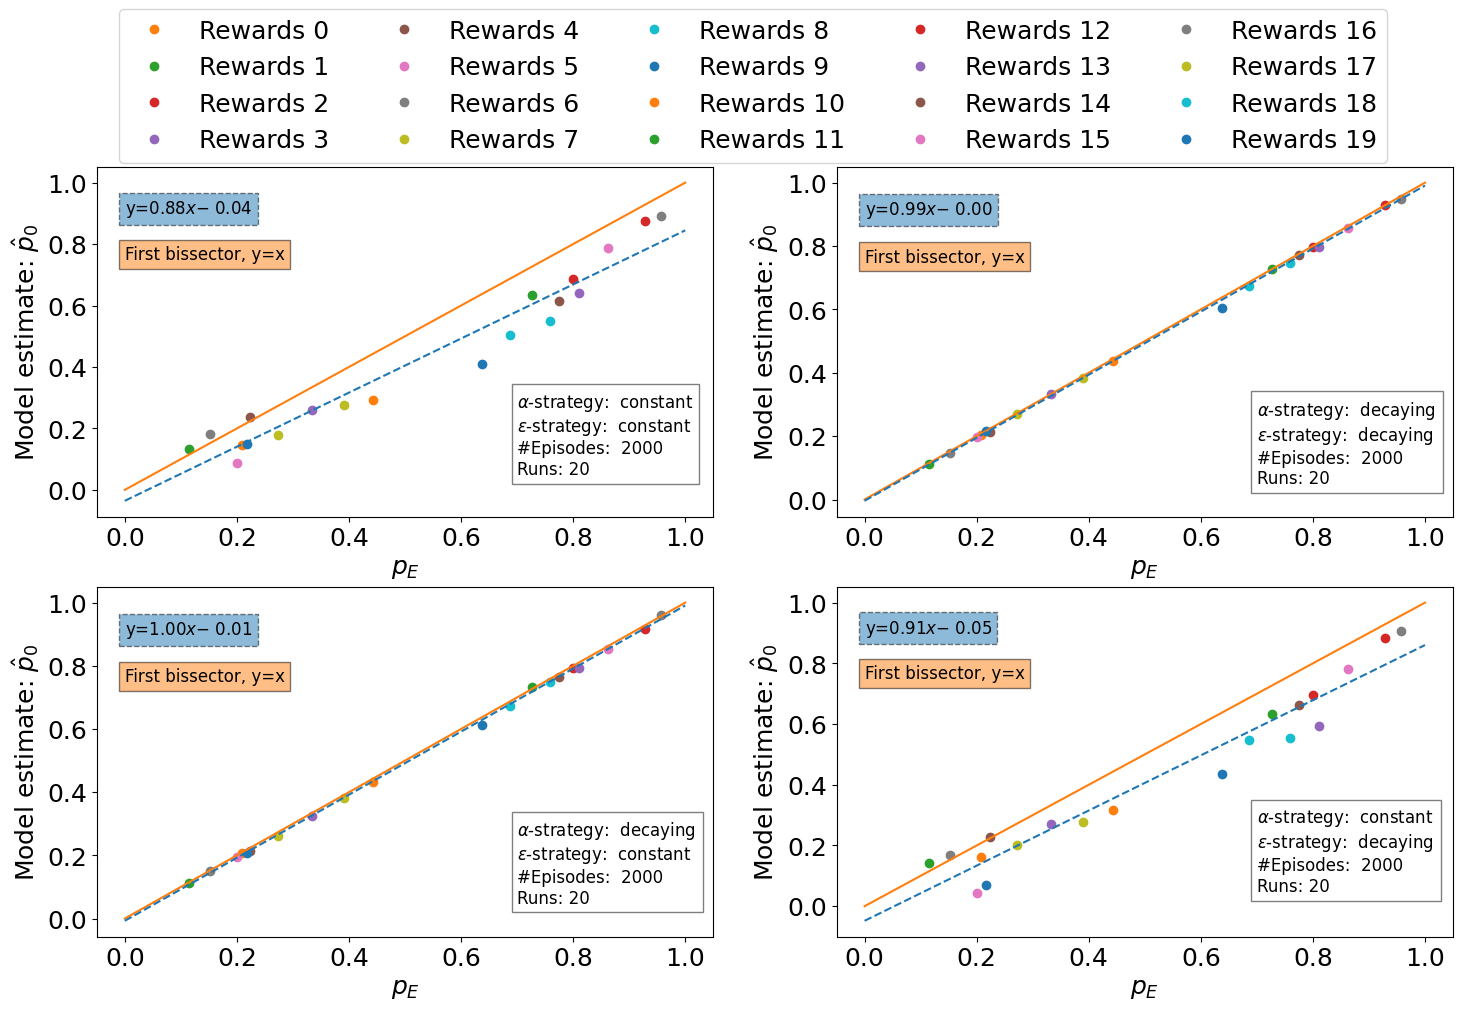

In [39]:
# ------------------------- [Visualization] -------------------------
policy_estimates = {}
strategy_iterator = 0
legend_string = list()

for decay_strategy, strategy_results in decay_model_results.items():
  policy_estimates[strategy_iterator] = {}
  for model_iterator, model_vars in strategy_results.items():
    reward1 = model_vars["rewards"][0]
    reward2 = model_vars["rewards"][1]
    reward3 = model_vars["rewards"][2]
    all_Q_values_single_round = model_vars["result"]
    # Calculate the critical p-value and k using the function for the final episode
    success, k_value, p0_value, std_p0, mean_probabilities, std_probabilities = calculate_p_values_and_k(all_Q_values_single_round, p_values, -1)

    # Calculate the critical p value using a helper function
    practical_p_critical = compute_critical_p(p_values, mean_probabilities)

    # Theoretical critical p-value based on reward structure
    if reward2 == 0:
      print_to_log(f"Resetting reward2 from {reward2} to 0.001 for log-transform on arithmetic average")
      reward2 = 0.001
    elif reward1 == reward2:
      print(f"Adding 0.001 to reward2 {reward2} for theoretical value calculation")
      reward2 += 0.001

    theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)

    theoretical_k = -(reward1 - reward2)
    time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))

    # Predicted values from the logistic function using the returned k-value
    fine_p_values = np.linspace(0,1,1000)
    predicted_probs = logistic(fine_p_values, k_value, p0_value)
    # predicted_probs = logistic(np.array(p_values), L_value, k_value, p0_value)

    policy_estimates[strategy_iterator][model_iterator] = [theoretical_p_critical, p0_value]

  strategy_iterator += 1

# with open(f"DecayStrat_policy_estimates.p","wb") as handle:
#     pickle.dump(policy_estimates, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot settings
fig, axs = plt.subplots(2, 2, figsize=(17.5, 10))
i = 0
j = 0

for decay_strategy, my_estimates in policy_estimates.items():
    x = np.linspace(0, 1, 1000)

    fit_input = list(my_estimates.values())
    my_p_data = np.swapaxes(np.array(fit_input),0,1) #  ,shape=(len(fit_input),2))
    params, covars = curve_fit(linear_fit, my_p_data[0], my_p_data[1], [1,0])

    print_to_log(f"Linear fitting Parameters for policy estimates: y={params[0]:.2f} x + {params[1]:.2f}")

    color_index = 1
    for key, value in my_estimates.items():
      axs[i][j].scatter(value[0],value[1], color=f"C{color_index}")
      color_index+=1
    
    axs[i][j].plot(x, x, linestyle="-",color=f"C{color_index}")
    axs[i][j].plot(x,linear_fit(x,params[0],params[1]),linestyle="--",color= f"C{0}") #, label=f"Fitted function: y={params[0]:.2f} x + {params[1]:.2f}")
    axs[i][j].set_xlabel(r"$p_{E}$",fontsize=split_figure*fs)
    axs[i][j].set_ylabel(f"Model estimate: " + r"$\hat{p}_{0}$",fontsize=split_figure*fs)
    axs[i][j].text(0.0,0.9, f"y={params[0]:.2f}" +"$x$" + f"{"$+$" if params[1]>=0 else "$-$"} {abs(params[1]):.2f}", fontsize=fs, bbox=dict(facecolor = f"C{0}", alpha = 0.5, linestyle="dashed"))
    axs[i][j].text(0.0,0.75, f"First bissector, y=x", fontsize=fs, bbox=dict(facecolor = f"C{color_index}", alpha = 0.5))
    axs[i][j].set_xticks(x_ticks)
    axs[i][j].set_xticklabels(x_ticks,fontsize=split_figure*ts)
    axs[i][j].set_yticks(y_ticks)
    axs[i][j].set_yticklabels(y_ticks,fontsize=split_figure*ts)# axs[i][j].text(0.7,0.05, f"Model {my_Id}", fontsize=12, bbox=dict(facecolor = f"white", alpha = 0.5))
    axs[i][j].text(0.7,0.05, r"$\alpha$-strategy: " + f" {decay_strategies[decay_strategy][0]} \n" + 
                   r"$\epsilon$-strategy: " + f" {decay_strategies[decay_strategy][1]} \n" + "#Episodes: " + 
                   f" {episodes} \n" + "Runs: " + f"{num_runs}", 
                   fontsize=ls, bbox=dict(facecolor = f"white", alpha = 0.5))
    if i:
      if j:
         i=0
      else:
         j=1
    else:
       i=1
color_index = 1
for reward_id, values in enumerate(reward_vectors):
   legend_string.append(Line2D([0], [0],
                                color=f"C{color_index}",
                                marker='o',
                                linestyle="",
                                label=f"Rewards {reward_id}"
                                )
   )
   color_index += 1

fig.legend(handles=legend_string, frameon=True, ncol=5, fontsize=split_figure*ls, loc='upper center', fancybox=True,  bbox_to_anchor=(0.25, 0.55,0.5,0.5))

plt.savefig(f"DecayStrategies.pdf",dpi = 600, bbox_inches="tight")

plt.show()


In [8]:
all_policy_estimates = {}
all_policy_estimates[" DecayStrategies"] = policy_estimates

# Models random reward sweep

In [9]:
print(f"Models training started at {dt.datetime.now()}")
# model_results = {}
for model_name in models:
    #all_Q_values_multiple_rounds = {}
    model_results[model_name] = {}
    # Loop through different numbers of rounds
    # for num_decisions in range(1, max_num_decisions + 1):
    for reward_id, rewards in enumerate(reward_vectors):
        model_results[model_name][reward_id] = {}
        model_results[model_name][reward_id]["rewards"] = rewards
        reward1 = rewards[0]
        reward2 = rewards[1]
        reward3 = rewards[2]
        # print(f"Training for reward vector {reward_id}, with rewards: ", rewards)
        all_Q_values_multiple_rounds = {}
        for p in p_values:
            all_Q_values_multiple_rounds[p] = {}
            for run in range(num_runs):
                epsilon_strategy = EpsilonStrategy(method=epsilon_method, initial_epsilon=epsilon_max, decay_rate = epsilon_rate, min_epsilon=epsilon_min)
                alpha_strategy = DecayStrategy(method=alpha_method, initial_value=alpha_max, decay_rate=alpha_rate, min_value=alpha_min)

                if model_name == "Single Round Model":
                    raw_Q_values = train_agent(p)
                elif model_name == "Q Learning":
                    raw_Q_values = train_QLearning(p, 1)
                elif model_name == "Sarsa":
                    raw_Q_values = train_Sarsa(p, 1)
                elif model_name == "MC":
                    raw_Q_values = train_MonteCarlo(p, 1, mc_update_frequency)
                elif model_name == "PTD":
                    raw_Q_values = PTD(p, 1)
                else:
                    print(f"Model {model_name} not reckognized")

                all_Q_values_multiple_rounds[p][run] = raw_Q_values
        model_results[model_name][reward_id]["result"] = all_Q_values_multiple_rounds
    print(f"Training {model_name} completed at {dt.datetime.now()}!")


Models training started at 2024-05-30 19:47:30.342621
Training Single Round Model completed at 2024-05-30 19:49:02.548488!
Training Q Learning completed at 2024-05-30 19:57:34.935300!
Training Sarsa completed at 2024-05-30 19:58:51.735848!
Training MC completed at 2024-05-30 20:00:47.503822!
Training PTD completed at 2024-05-30 20:02:15.495771!


## Visualization

<>:61: SyntaxWarning: invalid escape sequence '\h'
<>:61: SyntaxWarning: invalid escape sequence '\h'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3631/3218869617.py:61: SyntaxWarning: invalid escape sequence '\h'
  axes[x][y].set_ylabel("Estimated $\hat{p_{0}}$",fontsize=split_figure*fs)


Linear fitting Parameters for policy estimates: y=1.00 x + -0.01
Linear fitting Parameters for policy estimates: y=1.00 x + -0.01
Linear fitting Parameters for policy estimates: y=1.00 x + -0.00
Linear fitting Parameters for policy estimates: y=0.99 x + -0.01


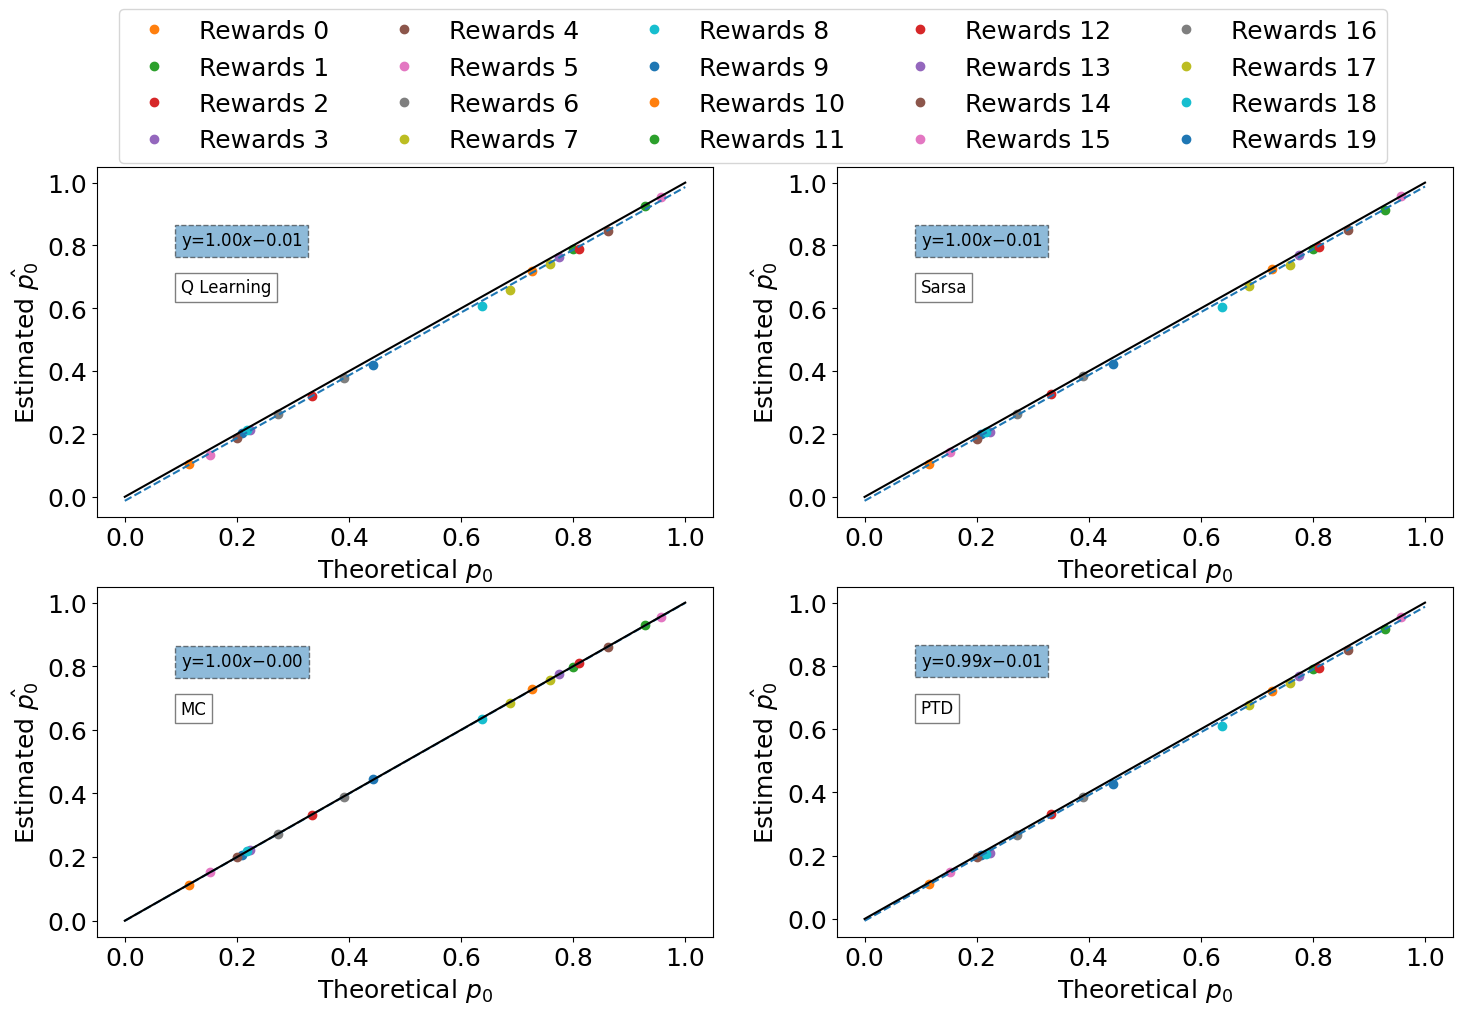

In [36]:
# policy_estimates = {}
x_len = int(len(models)/2)
y_len = len(models)-int(len(models)/2)
x_len=2
y_len =2
x_ticks = list(i/10 for i in range(0,11,2))
x_ticklabels = list(f"{i/10:.1f}" for i in range(0,11,2))
y_ticks = x_ticks
y_ticklabels = x_ticklabels
fig, axes = plt.subplots(x_len,y_len,figsize=(17.5,10))
x=0
y=0

x_ax = np.linspace(0, 1, 1000)
color_index = 1

# for model_name, model_data in model_results.items():
for model_name in models[1:]:
    model_data = model_results[model_name]
    all_policy_estimates[model_name] = {}
    for model_iterator, model_vars in model_data.items():
        reward1 = model_vars["rewards"][0]
        reward2 = model_vars["rewards"][1]
        reward3 = model_vars["rewards"][2]
        # all_Q_values_single_round = model_vars["result"]
        # Calculate the critical p-value and k using the function for the final episode
        success, k_value, p0_value, std_p0, mean_probabilities, std_probabilities = calculate_p_values_and_k(model_vars["result"], p_values, -1)

        # Calculate the critical p value using a helper function
        practical_p_critical = compute_critical_p(p_values, mean_probabilities)

        # Theoretical critical p-value based on reward structure
        theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
        theoretical_k = -(reward1 - reward2)
        time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))

        # Predicted values from the logistic function using the returned k-value
        fine_p_values = np.linspace(0,1,1000)
        predicted_probs = logistic(fine_p_values, k_value, p0_value)
        all_policy_estimates[model_name][model_iterator] = [theoretical_p_critical, p0_value]


    fit_input = list(all_policy_estimates[model_name].values())
    my_p_data = np.swapaxes(np.array(fit_input),0,1) #  ,shape=(len(fit_input),2))
    params, covars = curve_fit(linear_fit, my_p_data[0], my_p_data[1], [1,0])
    print(f"Linear fitting Parameters for policy estimates: y={params[0]:.2f} x + {params[1]:.2f}")
    color_index = 1


    for key, value in all_policy_estimates[model_name].items():
        # plt.scatter(list(policy_estimates.values()),list(policy_estimates.values()),label=model_iterator)
        axes[x][y].scatter(value[0],value[1],label=key)
        color_index+=1

    axes[x][y].plot(x_ax,linear_fit(x_ax,params[0],params[1]),linestyle="--",color= f"C{0}") #, label=f"Fitted function: y={params[0]:.2f} x + {params[1]:.2f}")

    # model_name = "PTD" if model_name == "II" else model_name
    axes[x][y].plot(x_ax, x_ax, linestyle="-",color=f"black")
    # plt.title(f"Policy estimates as function of rewards")
    axes[x][y].set_xlabel(f"Theoretical $p_{0}$", fontsize=split_figure*fs)
    axes[x][y].set_ylabel("Estimated $\hat{p_{0}}$",fontsize=split_figure*fs)
    axes[x][y].set_xticks(x_ticks)
    axes[x][y].set_xticklabels(x_ticks,fontsize=split_figure*ts)
    axes[x][y].set_yticks(y_ticks)
    axes[x][y].set_yticklabels(y_ticks,fontsize=split_figure*ts)
    # axes[x][y].legend(ncol=len(reward_vectors)/2-1, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axes[x][y].text(0.1,0.8, f"y={params[0]:.2f}" + "$x$" + f"{"$x$" if params[1]>=0 else "$-$"}{abs(params[1]):.2f}", fontsize=ls, bbox=dict(facecolor = f"C{0}", alpha = 0.5, linestyle="dashed"))
    axes[x][y].text(0.1,0.65, f"{model_name}", fontsize=ls, bbox=dict(facecolor = f"White", alpha = 0.5))

    # Plot number:
    if y < y_len-1:
        y += 1
    else:
        y = 0
    if x < x_len and y == 0:
        x += 1

# fig.legend(handles=legend_string, frameon=True, ncol=10, loc='upper center', fancybox=True,  bbox_to_anchor=(0.5, 1))
fig.legend(handles=legend_string, frameon=True, ncol=5, fontsize=split_figure*ls, loc='upper center', fancybox=True,  bbox_to_anchor=(0.25, 0.55,0.5,0.5))

plt.savefig("Model_RandomRewards.pdf",dpi=600 ,bbox_inches="tight", format='pdf')

plt.show()

In [11]:
with open(f"Hyperparameter_policies.p","wb") as handle:
    pickle.dump(all_policy_estimates, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saturation Analysis


<>:22: SyntaxWarning: invalid escape sequence '\h'
<>:60: SyntaxWarning: invalid escape sequence '\h'
<>:22: SyntaxWarning: invalid escape sequence '\h'
<>:60: SyntaxWarning: invalid escape sequence '\h'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3631/952453590.py:22: SyntaxWarning: invalid escape sequence '\h'
  """
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3631/952453590.py:60: SyntaxWarning: invalid escape sequence '\h'
  label = f"{model_name}: "+ "$\hat{p}_{0}$"+f"={p0_values[-1]:.2f}"


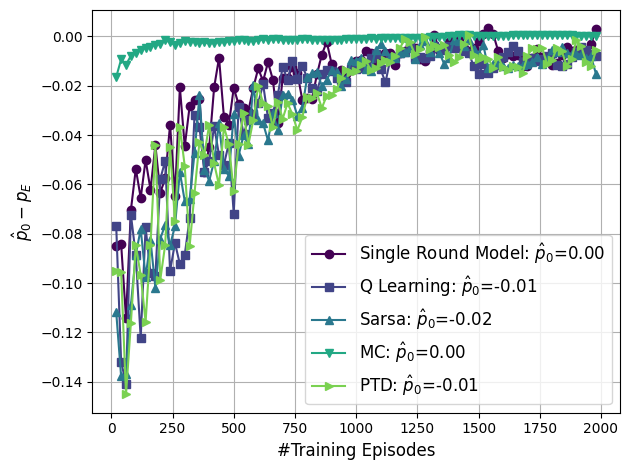

In [12]:
# ------------------------- [Saturation Analysis] -------------------------

num_data_points = 100
vision_index = 0
r_vec = random.randint(0,len(reward_vectors))


# Calculate episodes for which we will perform the analysis
episode_increment = episodes // num_data_points
selected_episodes = [episode_increment * i for i in range(1, num_data_points)]
selected_apisodes = selected_episodes[2:].append(episodes-1)

# Initialize lists to store critical p-values and slopes for each selected episode
p0_values = []
k_values = []
fitted_episodes = []

# markers = ['o', 's', '^', 'v', '>', '<', 'p', '*', '+', 'x']
# colors = plt.cm.viridis(np.linspace(0, 1, len(models)+1))
markers = ['o', 's', '^', 'v', '>', '<', 'p', '*', '+', 'x']
colors = plt.cm.viridis(np.linspace(0, 1, len(list(model_results.keys())) +1))
"""
for episode in selected_episodes:
    success, k, p0, std_p0,  _, _ = calculate_p_values_and_k(model_results["SingleRound"][3][0]['result'], p_values, episode)
    reward1 = model_results["SingleRound"][3][0]['rewards'][0]
    reward2 = model_results["SingleRound"][3][0]['rewards'][1]
    reward3 = model_results["SingleRound"][3][0]['rewards'][2]
    theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
    if success:
        p0_values.append((p0-theoretical_p_critical)/theoretical_p_critical)
        # p0_values.append(episode)
        k_values.append(k)
        fitted_episodes.append(episode)
# Plot critical p-values
plt.plot(fitted_episodes, p0_values,
            color=colors[vision_index],
            marker=markers[vision_index],
            label = "Single round model: $\hat{p}_{0}$"+f"={p0_values[-1]:.2f}"
            )
vision_index += 1 if vision_index < len(colors)-1 else 0
"""
for model_name in models:
    p0_values = []
    k_values = []
    fitted_episodes = []
    for episode in selected_episodes:
        success, k, p0, std_p0,  _, _ = calculate_p_values_and_k(model_results[model_name][r_vec]['result'], p_values, episode)
        reward1 = model_results[model_name][r_vec]['rewards'][0]
        reward2 = model_results[model_name][r_vec]['rewards'][1]
        reward3 = model_results[model_name][r_vec]['rewards'][2]
        theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
        if success:
            p0_values.append((p0 - theoretical_p_critical))
            k_values.append(k)
            fitted_episodes.append(episode)
    # Plot critical p-values
    plt.plot(fitted_episodes, p0_values,
             color=colors[vision_index],
             marker=markers[vision_index],
             label = f"{model_name}: "+ "$\hat{p}_{0}$"+f"={p0_values[-1]:.2f}"
             )
    vision_index += 1 if vision_index < len(colors)-1 else 0

plt.xlabel('#Training Episodes', fontsize=12)
plt.ylabel(r"$\hat{p}_{0} - p_{E}$",fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()


plt.savefig("Saturation.png",dpi=250 ,format='png')
plt.savefig("Saturation.pdf",dpi=250 ,format='pdf')

plt.show()


In [44]:
model_results[model_name][r_vec]['result'][0.0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

## Backup

In [13]:
if 0:
    # ------------------------- [Saturation Analysis] -------------------------

    num_data_points = 100
    vision_index = 0

    # Calculate episodes for which we will perform the analysis
    episode_increment = episodes // num_data_points
    selected_episodes = [episode_increment * i for i in range(1, num_data_points)]
    selected_apisodes = selected_episodes[2:].append(episodes-1)

    # Initialize lists to store critical p-values and slopes for each selected episode
    p0_values = []
    k_values = []
    L_values = []
    fitted_episodes = []
    for episode in selected_episodes:
        success, L, k, p0, std_p0,  _, _ = calculate_p_values_and_k(all_Q_values_single_round, p_values, episode)
        if success:
            p0_values.append((p0-theoretical_p_critical)/theoretical_p_critical)
            # p0_values.append(episode)
            k_values.append(k)
            L_values.append(L)
            fitted_episodes.append(episode)
    # Plot critical p-values
    plt.plot(fitted_episodes, p0_values,
                color=colors[vision_index],
                marker=markers[vision_index],
                label = "Single round model: $\hat{p_{0}}$"+f"={p0_values[-1]:.2f}"
                )
    vision_index += 1 if vision_index < len(colors)-1 else 0

    for model_name in models:
        p0_values = []
        k_values = []
        L_values = []
        fitted_episodes = []
        for episode in selected_episodes:
            success, L, k, p0, std_p0,  _, _ = calculate_p_values_and_k(model_results[model_name][1], p_values, episode)
            if success:
                p0_values.append((p0-theoretical_p_critical)/theoretical_p_critical)
                # p0_values.append(episode)
                k_values.append(k)
                L_values.append(L)
                fitted_episodes.append(episode)
        # Plot critical p-values
        plt.plot(fitted_episodes, p0_values,
                color=colors[vision_index],
                marker=markers[vision_index],
                label = f"{model_name}: "+ "$\hat{p_{0}}$"+f"={p0_values[-1]:.2f}"
                )
        vision_index += 1 if vision_index < len(colors)-1 else 0

    plt.xlabel('#Training Episodes', fontsize=12)
    plt.ylabel(r"$\frac{\hat{p_{0}} - p_{0}}{p_{0}}$",fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    plt.tight_layout()


    plt.savefig("Figure4.png",dpi=250 ,format='png')
    plt.savefig("Figure4.pdf",dpi=250 ,format='pdf')

    plt.show()


<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\h'
<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\h'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3631/1211737150.py:29: SyntaxWarning: invalid escape sequence '\h'
  label = "Single round model: $\hat{p_{0}}$"+f"={p0_values[-1]:.2f}"
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3631/1211737150.py:50: SyntaxWarning: invalid escape sequence '\h'
  label = f"{model_name}: "+ "$\hat{p_{0}}$"+f"={p0_values[-1]:.2f}"


# Remaining code from past copy

# Generic Game

In [14]:
if 0:
    fine_p_values = np.linspace(0,1,1000)
    theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
    theoretical_k = (reward1 - reward2)*20
    time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))
    predicted_probs = logistic(fine_p_values, 1, theoretical_k, theoretical_p_critical)

    plt.plot(fine_p_values, predicted_probs, color= '#1f77b4', linestyle='-', label="Sigmoid Curve")
    plt.axhline(0.5, color='black', linestyle='-')
    plt.axvline(theoretical_p_critical, color='#1f77b4', linestyle=':', label=r'$p_{E}$='+f'{theoretical_p_critical:.2f}') #, k: {-(k_value/4):.2f}')
    plt.axvline(time_average_growth, color='#ff7f0e', linestyle=':', label=r'$p_{T}$='+f'{time_average_growth:.2f}')

    plt.xlabel('Chance for the worst possible outcome ($p$) on the risky bet')
    plt.ylabel('Probability for chosing the safe action')

    plt.text(0.65,0.7, r"$\Uparrow$ safe", fontsize=26)
    plt.text(0.0,0.3, r"$\Downarrow$ risk", fontsize=26)

    plt.legend(loc="upper left")
    plt.grid(True)

    """ Only activate this block for saving output to file
    plt.savefig("GenericLogistic.png",dpi=250 ,format='png')
    plt.savefig("GenericLogistic.pdf",dpi=250 ,format='pdf')
    """

# Generic Game Time Average Growth

In [15]:
if 0:
    fine_p_values = np.linspace(0,1,1000)
    theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
    theoretical_k = (reward1 - reward2)*20
    time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))
    predicted_probs = logistic(fine_p_values, 1, theoretical_k, theoretical_p_critical)
    plt.plot(fine_p_values, predicted_probs, color='#1f77b4', linestyle='-', label="Expected Value policy")
    predicted_probs = logistic(fine_p_values, 1, theoretical_k, time_average_growth)
    plt.plot(fine_p_values, predicted_probs, color='#ff7f0e', linestyle='--', label="Time-Optimal policy")

    plt.axhline(0.5, color='black', linestyle='-')
    plt.axvline(theoretical_p_critical, color='#1f77b4', linestyle=':', label=r'$p_{E}$='+f'{theoretical_p_critical:.2f}') #, k: {-(k_value/4):.2f}')
    plt.axvline(time_average_growth, color='#ff7f0e', linestyle=':', label=r'$p_{T}$='+f'{time_average_growth:.2f}')

    plt.xlabel('Chance for the worst possible outcome ($p$) on the risky bet')
    plt.ylabel('Probability for chosing the safe action')

    plt.text(0.65,0.7, r"$\Uparrow$ safe", fontsize=26)
    plt.text(0.0,0.3, r"$\Downarrow$ risk ", fontsize=26)

    plt.legend(loc="upper left")
    plt.grid(True)


    """ Only activate this block for saving output to file
    plt.savefig("GenericMultipleLogistic.png",dpi=250 ,format='png')
    plt.savefig("GenericMultipleLogistic.pdf",dpi=250 ,format='pdf')
    """

In [40]:
os.getcwd()

'/Users/bertverbruggen/Library/CloudStorage/OneDrive-VrijeUniversiteitBrussel/Documenten/Documents/Onderzoek/IntegratedIntelligence/RL_Experiment/Paper2023/paper/Data/Data_Analysis/GitHub_Publication/Hyperparameter_Sweep'